In [496]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
IMAGE_SIZE = 72

def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

In [497]:
def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)

In [498]:
def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)


In [499]:
def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]


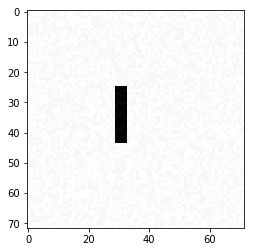

In [500]:
im = generate_a_rectangle(10, True)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

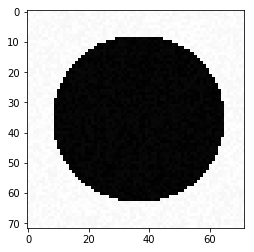

In [501]:
im = generate_a_disk(10)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

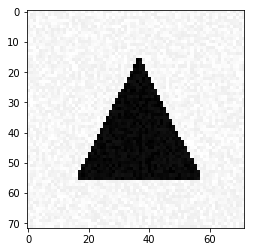

In [502]:
[im, v] = generate_a_triangle(20)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

In [503]:
def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

In [504]:
from keras.utils import np_utils,to_categorical
def generate_test_set_classification():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, True)
    Y_test = np_utils.to_categorical(Y_test, 3) 
    return [X_test, Y_test]

In [505]:
def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

In [506]:
import matplotlib.patches as patches

def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

    plt.show()

In [508]:
def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    return [X_test, Y_test]

3 Simple Classification
Build and train a linear classifier in Keras to classify a image into one of the three possible categories (i.e. rectangle, disk, triangle). Try using the stochastic gradient descent optimizer, then the Adam optimizer.

In [331]:
[X_train, Y_train] = generate_dataset_classification(300, 20)
Y_train=to_categorical(Y_train)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [317]:
print(X_train.shape)
print(Y_train.shape)

(300, 5184)
(300, 3)


In [525]:
from keras.models import Sequential
from keras.layers import Dense, Activation,BatchNormalization
from keras.optimizers import SGD
import tensorflow as tf
# build the model
model = Sequential()
model.add(BatchNormalization(input_shape=(IMAGE_SIZE**2,)))
model.add(Dense(1024,activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(512,activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(512,activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(512,activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(256,activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(3,activation='softmax'))
#define SGD optimizer
sgd = SGD(lr=0.01,decay=1e-6, momentum=0.9,nesterov=True)
model.compile(loss='categorical_crossentropy',optimizer='sgd',metrics=['accuracy'])
#model.fit(X_train, Y_train, epochs=5, batch_size=32)

In [528]:
from keras.optimizers import Adam
model = Sequential()
model.add(BatchNormalization(input_shape=(IMAGE_SIZE**2,)))
model.add(Dense(1024,activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(512,activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(512,activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(512,activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(256,activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(3,activation='softmax'))
#define Adam optimizer
adam = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.fit(X_train, Y_train, epochs=5, batch_size=32)

4 Visualization of the Solution
Visualize the weights of the linear classifier.

(5184,)
(5184,)
(5184,)
(5184,)
(5184, 1024)
(1024,)
(1024, 512)
(512,)
(512, 512)
(512,)
(512, 512)
(512,)
(512, 256)
(256,)
(256, 3)
(3,)


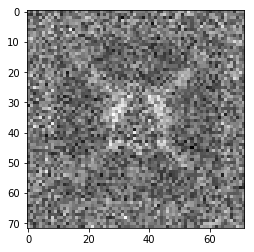

In [345]:
weight=model.get_weights()
for i in weight:
    print(i.shape)
    
plt.imshow(weight[0].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

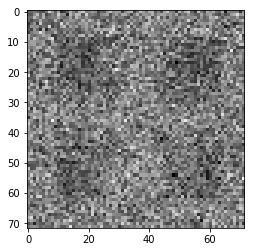

In [339]:
plt.imshow(weight[1].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

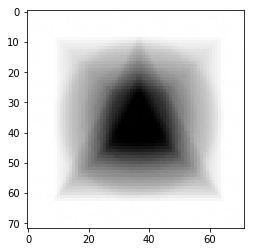

In [340]:
plt.imshow(weight[2].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

5 A More Difficult Classification Problem
Train a convolutional (not-to-)deep network on this new dataset.

In [452]:
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
[X_train, Y_train] = generate_dataset_classification(1000, 20, True)
Y_train=to_categorical(Y_train)
X_train = X_train.reshape(X_train.shape[0], 72,72,1)
X_train = X_train.astype('float32')

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990


In [453]:
from keras.optimizers import Adam
model = Sequential()
model.add(Conv2D(16, kernel_size=(5, 5),padding="same",activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2),padding="same"))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(3,activation='softmax'))
adam = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.fit(X_train, Y_train, epochs=10, batch_size=32)

Epoch 1/10
1000/1000 [==============================] - 50s 50ms/step - loss: 3.6414 - acc: 0.3800
Epoch 2/10
1000/1000 [==============================] - 11s 11ms/step - loss: 0.7630 - acc: 0.6620
Epoch 3/10
1000/1000 [==============================] - 11s 11ms/step - loss: 0.5036 - acc: 0.8170
Epoch 4/10
1000/1000 [==============================] - 11s 11ms/step - loss: 0.3474 - acc: 0.8820
Epoch 5/10
1000/1000 [==============================] - 11s 11ms/step - loss: 0.2531 - acc: 0.9190
Epoch 6/10
1000/1000 [==============================] - 11s 11ms/step - loss: 0.1601 - acc: 0.9600
Epoch 7/10
1000/1000 [==============================] - 11s 11ms/step - loss: 0.1032 - acc: 0.9740
Epoch 8/10
1000/1000 [==============================] - 11s 11ms/step - loss: 0.0760 - acc: 0.9890
Epoch 9/10
1000/1000 [==============================] - 11s 11ms/step - loss: 0.0364 - acc: 0.9980
Epoch 10/10
1000/1000 [==============================] - 11s 11ms/step - loss: 0.0209 - acc: 0.9980


In [460]:
[X_test, Y_test] = generate_test_set_classification()
X_test=X_test.reshape(X_test.shape[0], 72,72,1)
X_test = X_test.astype('float32')
model.evaluate(X_test, Y_test)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300/300 [==============================] - 7s 25ms/step


[0.4632163135210673, 0.83]

6 A Regression Problem
The task now is to predict the image locations of the vertices of a triangle, given an image of this triangle. 

In [ ]:
#Generating training and test data
[X_train, Y_train] = generate_dataset_regression(300, 20)
[X_test, Y_test] = generate_test_set_regression()
#visualization
visualize_prediction(X_train[0], Y_train[0])

In [515]:
#Transforming the data
nb_train = len(X_train)
nb_test = len(X_test)
y_train = np.zeros([nb_train, 6])
y_test = np.zeros([nb_test, 6])
#normalization
for i in range(nb_train):
    y_train[i] = (y_train[i] - y_train[i].mean()) / y_train[i].std()
for i in range(nb_test):
    y_test[i] = (y_test[i] - y_test[i].mean()) / y_test[i].std()
#reshape
x_train = X_train.reshape(len(X_train), 72, 72, 1)
x_test = X_test.reshape(len(X_test), 72, 72, 1)
    
#build the neural network
model = Sequential()
model.add(Conv2D(32, (3, 3),activation="relu", input_shape=(72, 72, 1),padding="same"))
model.add(MaxPooling2D(pool_size=(2, 2), padding="same"))
    
model.add(Conv2D(32,  activation="relu", padding="same"))
model.add(MaxPooling2D(pool_size=(2, 2), padding="same"))
    
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(6))

adam = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
model.fit(x_train, y_train, epochs=5, batch_size=32)


Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


D:\anaconda\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
D:\anaconda\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


Epoch 1/6
300/300 [==============================] - 46s 152ms/step - loss: nan - acc: 0.8933
Epoch 2/6
300/300 [==============================] - 3s 10ms/step - loss: nan - acc: 1.0000
Epoch 3/6
300/300 [==============================] - 2s 7ms/step - loss: nan - acc: 1.0000
Epoch 4/6
300/300 [==============================] - 2s 7ms/step - loss: nan - acc: 1.0000
Epoch 5/6
300/300 [==============================] - 2s 7ms/step - loss: nan - acc: 1.0000
Epoch 6/6
300/300 [==============================] - 2s 7ms/step - loss: nan - acc: 1.0000


In [516]:
model.evaluate(x_test, y_test)

300/300 [==============================] - 9s 31ms/step


[nan, 1.0]

7 Image Denoising